# Objetivo

Este notebook tem como objetivo aplicar um modelo de Machine Learning para prever a sobrevivência dos passageiros do Titanic, utilizando Random Forest como classificador.

# Bibliotecas Utilizadas

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score

# Dataset train

Antes de aplicar o modelo, é necessário tratar a base de dados, pois o scikit-learn não lida diretamente com valores nulos ou variáveis categóricas. Para isso, vamos preencher os dados ausentes e transformar as variáveis categóricas relevantes em dummies.

In [122]:
df_train = pd.read_csv('train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [123]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [124]:
#verificando valores nulos
df_train.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [125]:
#tratando valores nulos de df_train
df_train['Age'] = df_train.Age.fillna(df_train.Age.median())
df_train['Embarked'] = df_train['Embarked'].fillna(df_train['Embarked'].mode()[0])

In [126]:
#removendo variáveis que não serão úteis no modelo
df_train.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'], inplace=True)

In [127]:
#transformando dummies
df_train = pd.get_dummies(df_train, drop_first=True)

In [128]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Sex_male    891 non-null    bool   
 7   Embarked_Q  891 non-null    bool   
 8   Embarked_S  891 non-null    bool   
dtypes: bool(3), float64(2), int64(4)
memory usage: 44.5 KB


# Modelo

In [129]:
#variáveis preditoras e variável resposta
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']

#dividindo a base em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [130]:
#definindo o intervalos de busca para otimização dos hiperparâmetros do Random Forest
param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': range(2, 30, 1),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': np.linspace(0, 0.005, 10)
}

#configurando do K-Fold estratificado para validação cruzada
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

#aplicando RandomizedSearchCV para encontrar a melhor combinação de hiperparâmetros
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=0),
    param_distributions=param_dist,
    n_iter=50,
    cv=kf,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=0
)

In [131]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=RandomForestClassifier(random_state=0), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': array([0.        , 0.00055556, 0.00111111, 0.00166667, 0.00222222,
       0.00277778, 0.00333333, 0.00388889, 0.00444444, 0.005     ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 30),
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300,
                                                         500]},
                   random_state=0, scoring='roc_auc', verbose=1)

In [132]:
print(f"Melhores hiperparâmetros: {random_search.best_params_}")
print(f"AUC média na validação cruzada: {random_search.best_score_:.4f}")

Melhores hiperparâmetros: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy', 'ccp_alpha': np.float64(0.005), 'bootstrap': True}
AUC média na validação cruzada: 0.8598


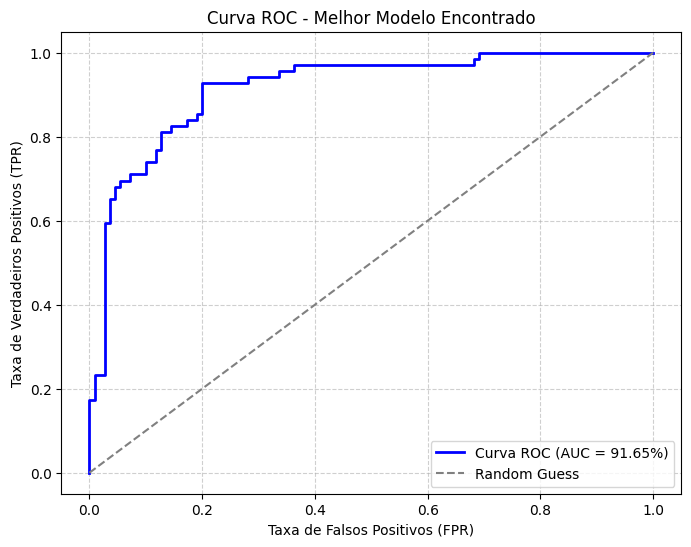

AUC: 91.65%
Gini: 83.29%


In [133]:
#melhor modelo encontrado pelo RandomizedSearchCV
melhor_modelo = random_search.best_estimator_

#previsão das probabilidades da classe positiva
melhor_prob = melhor_modelo.predict_proba(X_test)[:, 1]

#calculando a Curva ROC
fpr, tpr, _ = roc_curve(y_test, melhor_prob)
roc_auc = auc(fpr, tpr)

#calculando o Coeficiente de Gini
gini = 2 * roc_auc - 1

#plotando a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2%})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.5, label="Random Guess")
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Melhor Modelo Encontrado')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#exibir AUC e Gini formatados em porcentagem
print(f"AUC: {roc_auc:.2%}")
print(f"Gini: {gini:.2%}")

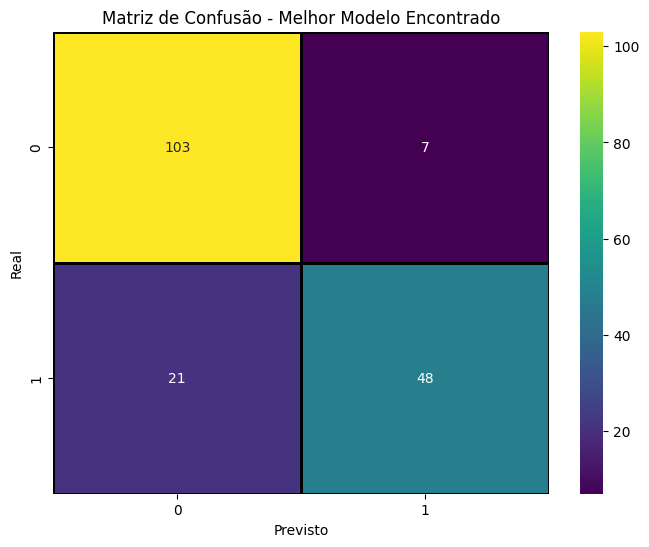

Acurácia: 84.36%
Acurácia Balanceada: 81.60%
Precisão (PPV): 87.27%
Sensibilidade (Recall/TPR): 69.57%
Especificidade (TNR): 93.64%
F1-Score: 77.42%
Taxa de Falsos Positivos (FPR): 6.36%
Taxa de Falsos Negativos (FNR): 30.43%


In [134]:
#fazer previsões no conjunto de teste
melhor_predict = melhor_modelo.predict(X_test)

#calculando a Matriz de Confusão
conf_matrix = confusion_matrix(y_test, melhor_predict)

#exibindo figura
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", linewidths=2, linecolor='black')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Melhor Modelo Encontrado")
plt.show()

#extração dos valores da Matriz de Confusão
TN, FP, FN, TP = conf_matrix.ravel()

#calculando métricas
ac = accuracy_score(y_test, melhor_predict) * 100
bac = balanced_accuracy_score(y_test, melhor_predict) * 100
precision = precision_score(y_test, melhor_predict) * 100
recall = recall_score(y_test, melhor_predict) * 100
f1 = f1_score(y_test, melhor_predict) * 100
specificity = (TN / (TN + FP)) * 100 if (TN + FP) > 0 else 0
FPR = (FP / (FP + TN)) * 100 if (FP + TN) > 0 else 0
FNR = (FN / (FN + TP)) * 100 if (FN + TP) > 0 else 0

#exibir métricas formatadas em porcentagem
print(f"Acurácia: {ac:.2f}%")
print(f"Acurácia Balanceada: {bac:.2f}%")
print(f"Precisão (PPV): {precision:.2f}%")
print(f"Sensibilidade (Recall/TPR): {recall:.2f}%")
print(f"Especificidade (TNR): {specificity:.2f}%")
print(f"F1-Score: {f1:.2f}%")
print(f"Taxa de Falsos Positivos (FPR): {FPR:.2f}%")
print(f"Taxa de Falsos Negativos (FNR): {FNR:.2f}%")

# tratamento dos dados df_train

In [135]:
#importando base de teste
df_test = pd.read_csv('test.csv', index_col="PassengerId")
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [136]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [137]:
#substituindo valores nulos
df_test['Age'] = df_test.Age.fillna(df_test.Age.median())
df_test['Fare'] = df_test.Fare.fillna(df_test.Fare.median())

In [138]:
#removendo colunas irrelevantes de df_test
df_test.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)

In [139]:
#transformando dummies
df_test = pd.get_dummies(df_test, drop_first=True)

# Aplicando o modelo para os novos dados

Agora, o objetivo é aplicar o modelo a novos dados, gerar as previsões e exportá-las em um arquivo CSV para submissão no Kaggle, onde o desempenho será avaliado.

In [145]:
#utilizando o modelo para fazer as previsões de survived para df_test
previsoes_df_test = melhor_modelo.predict(df_test)
previsoes_df_test

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

# Arquivo de submissão

In [146]:
df_test_reload = pd.read_csv('test.csv')
submission = pd.DataFrame({'PassengerId': df_test_reload['PassengerId'], 'Survived': previsoes_df_test})

In [147]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [143]:
submission.to_csv('submission.csv', index=False)